In [1]:
import pydicom as dicom
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import scipy.ndimage
from exercises_code import *
import glob


In [2]:
%load_ext autoreload
%autoreload 2

# Co-Registration of Input Images given reference image

In medical imaging, co-registration refers to the process of aligning or matching two or more images of the same scene or object taken from different perspectives, modalities, or time points. The goal of co-registration is to ensure that corresponding structures or features in the images are spatially aligned with each other.

In this case, we have reference image.

Input images: RM Brain 3D-SPGR folder

Reference image: icbm_avg_152_t1_tal_nlin_symmetric_VI

let's load up the data first

In [6]:
# let's load up reference dcm
ref_dcm = dicom.read_file('./p2data/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm')
ref_block = ref_dcm.pixel_array

# currently, let's assume the input data is as nice as previous part
# ask Pedro if it's alright to assume that 
input_glob = './p2data/RM_Brain_3D-SPGR/*.dcm'
input_files = glob.glob(input_glob)
input_dcms = [
    dicom.dcmread(f) for f in input_files
]
# we are doing alot of assumption that Slice location exists
# and that the data is as nice as the pervious part
slice_to_pixel = {
    input_dcm.SliceLocation : input_dcm.pixel_array for input_dcm in input_dcms
}
input_block = np.array(
    [
        slice_to_pixel[k] for k in sorted(slice_to_pixel.keys())
    ]
)
assert len(input_dcms) == len(slice_to_pixel.keys()), "Slice location different from input files! Repeated Slice Location!"
print("input block shape:", input_block.shape)
print("reference block shape:", ref_dcm.pixel_array.shape)


input block shape: (212, 512, 512)
reference block shape: (193, 229, 193)


Observe above that the shape for input and reference is not the same let's plot data here and do an observation.

We show median of both images on all axis (axia, coronal, sagittal) 

Slice Thickness 2
Pixel Spacing [0.5078, 0.5078]


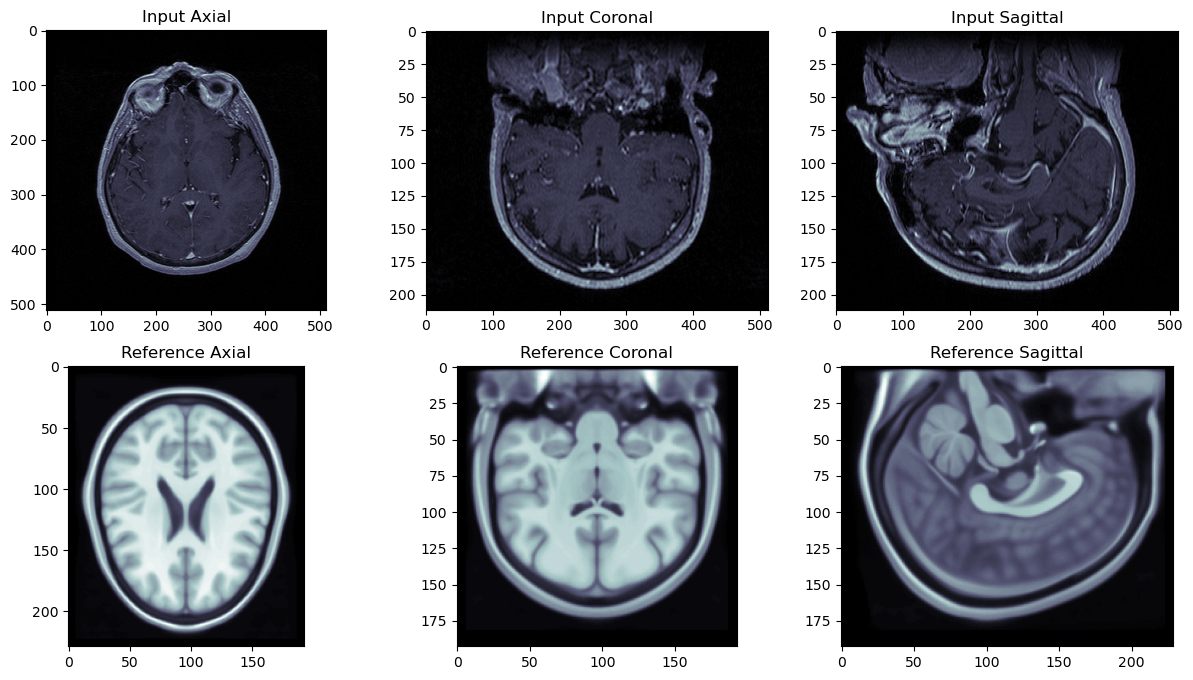

In [23]:
# let's get aspect ratio first
slice_thickness = input_dcms[0].SliceThickness # I think it's all the same for all slice if it follows part1 style 
pixel_spacing = input_dcms[0].PixelSpacing # I think it's all the same for all slice if it follows part1 style 
print('Slice Thickness', slice_thickness)
print('Pixel Spacing', pixel_spacing)
pixel_len_mm = [float(input_dcms[0].SliceThickness),
                input_dcms[0].PixelSpacing[0],
                input_dcms[0].PixelSpacing[1]]
aspect_ratio = pixel_len_mm[0] / pixel_len_mm[1]


def plot_image_and_reference_comparison(
        image_block: np.array, 
        reference_block: np.array, 
        img_aspect: float = 1.0/pixel_spacing[0], 
        ref_aspect = None):
    plt.figure(figsize=(15, 8))
    
    plt.subplot(2, 3, 1)
    plt.imshow(median_axial_plane(image_block), cmap='bone')
    plt.title("Input Axial")
    
    plt.subplot(2, 3, 2)
    plt.imshow(median_coronal_plane(image_block), cmap='bone', aspect=img_aspect)
    plt.title("Input Coronal")
    
    plt.subplot(2, 3, 3)
    plt.imshow(median_sagittal_plane(image_block), cmap='bone', aspect=img_aspect)
    plt.title("Input Sagittal")
    
    plt.subplot(2, 3, 4)
    plt.imshow(median_axial_plane(reference_block), cmap='bone')
    plt.title("Reference Axial")
    
    plt.subplot(2, 3, 5)
    plt.imshow(median_coronal_plane(reference_block), cmap='bone', aspect=ref_aspect)
    plt.title("Reference Coronal")
    
    plt.subplot(2, 3, 6)
    plt.imshow(median_sagittal_plane(reference_block), cmap='bone', aspect=ref_aspect)
    plt.title("Reference Sagittal")
    
    plt.show()
    
plot_image_and_reference_comparison(image_block=input_block, reference_block=ref_block, img_aspect=1.0/pixel_spacing[0])



There are 2 main issues:
1. reference is smaller than input
2. Input Axial and Reference axial is.... upside down???? It seems like it. 

These issues can be solved initially (not the best but initially) by following ways. 

Issue 1 can be solved in 2 ways:
1. downsize the input
2. pad the reference 

Issue 2 we will try to solve by rotation on axial plane by 180.

Since issue 2 seems easier we can do that first

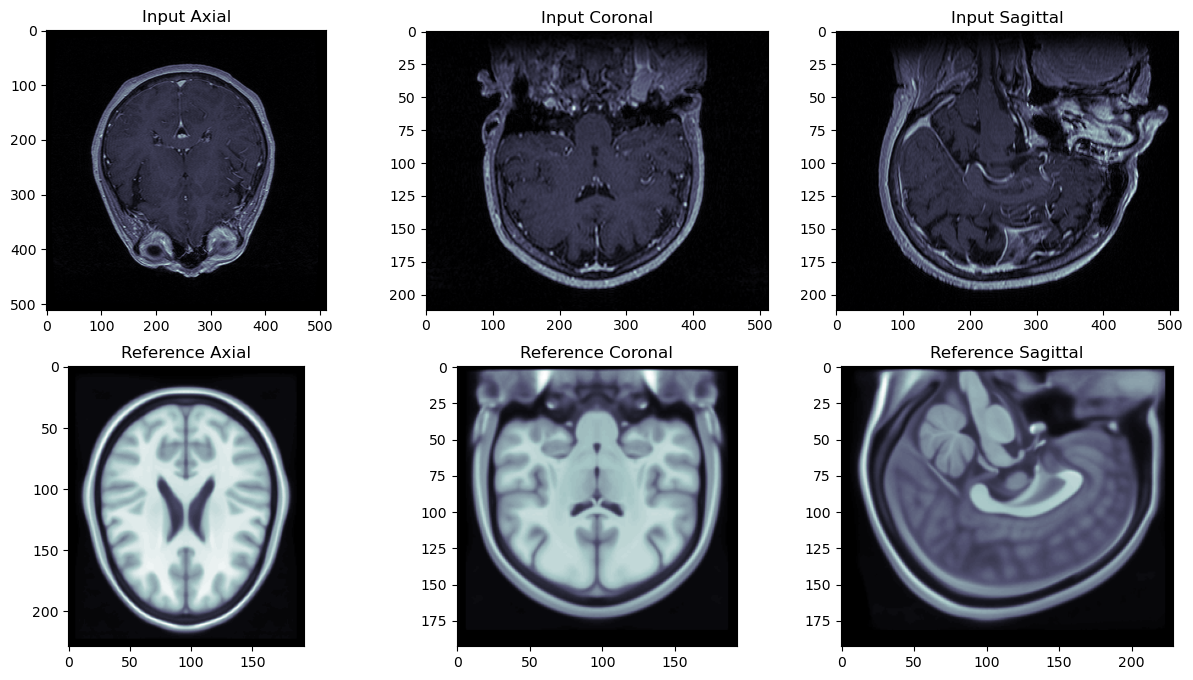

In [16]:
rot_block = input_block.copy()
rot_block = rotate_on_axial_plane(rot_block, 180)
plot_image_and_reference_comparison(image_block=rot_block, reference_block=ref_block, pixel_spacing=pixel_spacing[0])


Much better, I wonder if the Sagittal plane is correct but it looks correct. 


Now that we have solved the axial rotation issue. Let's solve the dimension alignment issue.

It seems that, from the plot, that the voxels are different. 

We shall first perform up-sampling of reference block onto the rotated block via interpolation.  

Here's some definition of resampling using interpolation: 

Resampling Using Interpolation: Adjust the voxel size of one block to match the other by interpolating the data points. This can involve upsampling (increasing resolution) or downsampling (decreasing resolution) and typically uses interpolation techniques like nearest neighbor, linear, or spline interpolation.


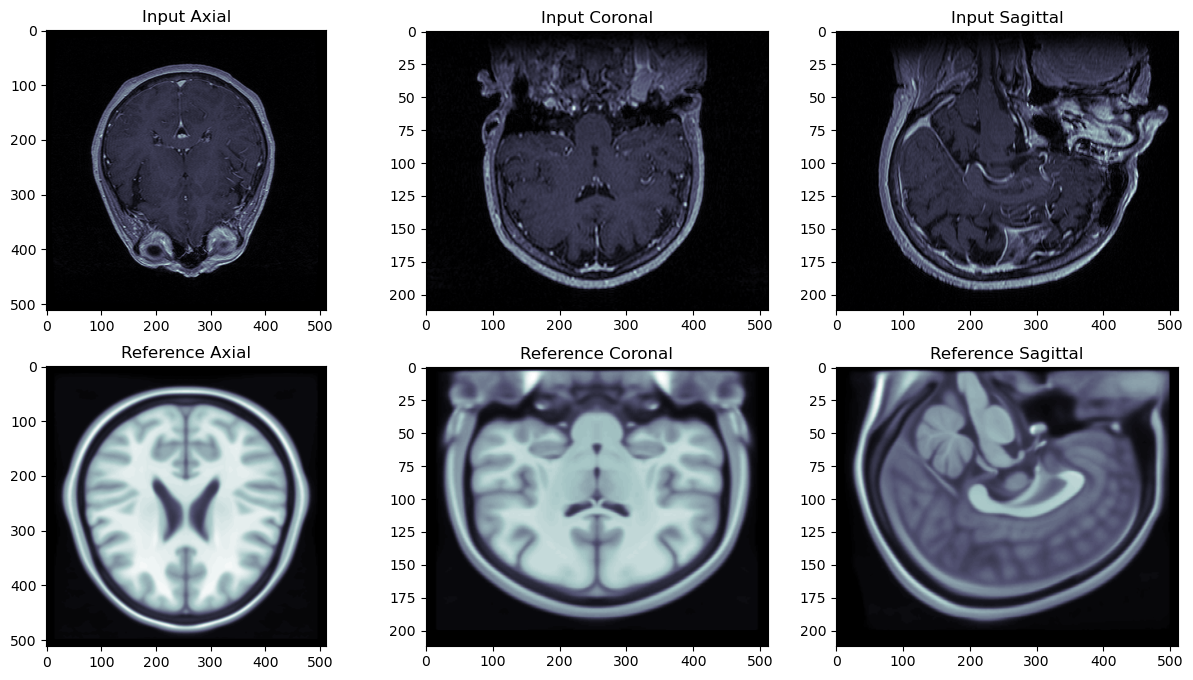

In [29]:
reference_shape = ref_block.shape
input_shape = input_block.shape

reference_pixel_spacing = [
    (reference_shape[1] * pixel_spacing[0]) / input_shape[1],
    (reference_shape[2] * pixel_spacing[1]) / input_shape[2]
]
reference_slice_thickness = (reference_shape[0] * slice_thickness) / input_shape[0]

zoom_factors = [
    slice_thickness / reference_slice_thickness,
    input_shape[1] / reference_shape[1],
    input_shape[2] / reference_shape[2]
]

resampled_reference = scipy.ndimage.zoom(ref_block, zoom_factors, order=1)
plot_image_and_reference_comparison(image_block=rot_block,
                                    reference_block=resampled_reference,
                                    img_aspect=1.0/pixel_spacing[0],
                                    ref_aspect=1.0/pixel_spacing[0])

Problem with above method, as we can see, the resampling issue makes the reference bigger than it should be. 

So what we are going to do instead is to pad 0s in all direction 


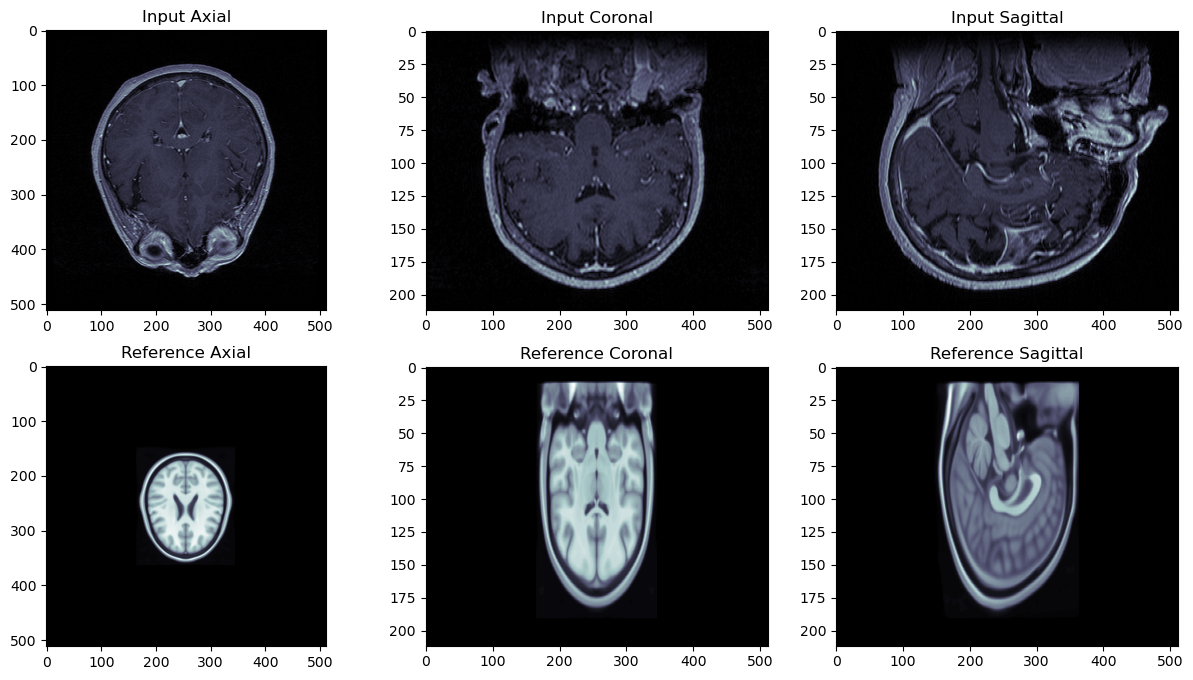

In [33]:
def pad(image_block, reference_block):
    input_shape = image_block.shape
    reference_shape = reference_block.shape
    # Calculate padding needed for each dimension
    padding = [(0, target - original) for target, original in zip(input_shape, reference_shape)]
    
    # Calculate padding to center the original data in the new size
    # This computes how much padding is needed on each side of each dimension
    padded_shape = [(pad[1]//2, pad[1] - pad[1]//2) for pad in padding]
    
    # Apply padding
    padded_reference_block = np.pad(reference_block.copy(), pad_width=padded_shape, mode='constant', constant_values=0)
    return padded_reference_block

padded_reference_block = pad(rot_block, ref_block)
plot_image_and_reference_comparison(image_block=rot_block,
                                    reference_block=padded_reference_block,
                                    img_aspect=1.0/pixel_spacing[0],
                                    ref_aspect=1.0/pixel_spacing[0])


Ok that's not good

I think we could try both?

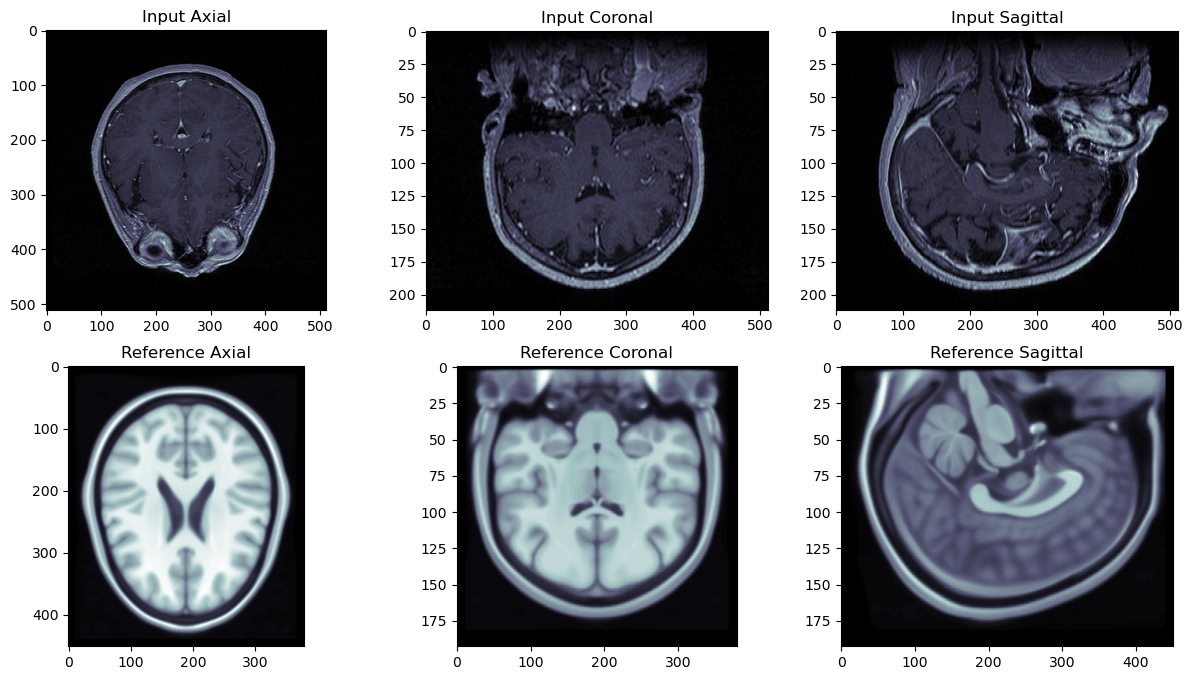

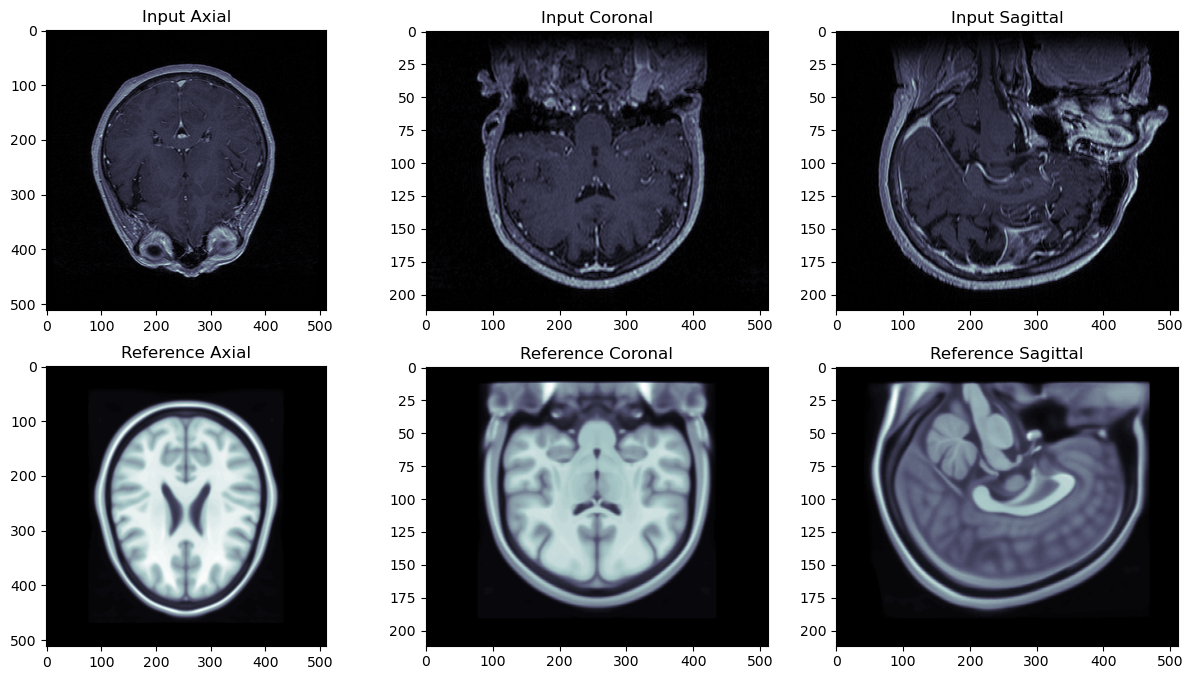

In [35]:
zoom_factors = [
    1, 
    1 / pixel_spacing[0],
    1 / pixel_spacing[0]
]
resampled_reference = scipy.ndimage.zoom(ref_block, zoom_factors, order=1)
plot_image_and_reference_comparison(image_block=rot_block,
                                    reference_block=resampled_reference,
                                    img_aspect=1.0/pixel_spacing[0],
                                    ref_aspect=1.0/pixel_spacing[0])
padded_reference_block = pad(rot_block, resampled_reference)
plot_image_and_reference_comparison(image_block=rot_block,
                                    reference_block=padded_reference_block,
                                    img_aspect=1.0/pixel_spacing[0],
                                    ref_aspect=1.0/pixel_spacing[0])

# Optimization 

Previous upscaling and padding makes it much better but not perfect. 

However, notice that some axial rotation and positioning is off. So we will further do optimization in order to move.

It would be interesting if I can integrate process above as part of optimization (eg the zoom factor) 

Now we run into the final issue.

Despite our best effort in scaling and padding. The data is actually slightly off. Therefore, we should perform some translation and rotation in order to get the best matching. However, this is difficult and therefore, we will perform optimization technique. 
 


In [101]:
import numpy as np
import scipy.ndimage
import scipy.optimize

def to_radian(angle):
    return angle * np.pi / 180

def find_centroid_block(block):
    # cant use find_centroid cus it's == 1
    idcs = np.where(block != 0)
    centroid = np.stack([
        np.mean(idcs[0]),
        np.mean(idcs[1]),
        np.mean(idcs[2]),
    ])
    return centroid 

def transform_block(params, original_block):
    """
    Apply translation and rotation to the reference block.
    params: [trans_x, trans_y, trans_z, angle_x, angle_y, angle_z]
    reference_block: 3D numpy array (the reference image block)
    """
    trans_x, trans_y, trans_z, angle_x, angle_y, angle_z = params

    # Apply translation
    translated = np.roll(original_block, np.array(params[:3]).astype(int), axis=(0, 1, 2))

    # Apply rotation
    rotated = scipy.ndimage.rotate(translated, to_radian(angle_x), axes=(1, 2), reshape=False)
    rotated = scipy.ndimage.rotate(rotated, to_radian(angle_y), axes=(0, 2), reshape=False)
    rotated = scipy.ndimage.rotate(rotated, to_radian(angle_z), axes=(0, 1), reshape=False)

    return rotated


def coregister_image(
        image_block, 
        reference_block,
        method='GD'):
    centroid_img = find_centroid_block(image_block)
    centroid_ref = find_centroid_block(reference_block)
    
    translation_vector = centroid_img - centroid_ref 
    initial_parameters = [
        0, 0, 0,    # Translation vector
        0, 0, 0     #
    ]
    initial_parameters[0] = translation_vector[0]
    initial_parameters[1] = translation_vector[1]
    initial_parameters[2] = translation_vector[2]
    initial_parameters[3] = np.pi
    errors = [] # check if optimizing

    def loss_function(params):
        transformed_block = transform_block(params, image_block)
        err = np.mean((reference_block - transformed_block)**2)
        errors.append(err)
        return err
    
    # Run optimization
    result = None
    if "GD" == method:
        result = scipy.optimize.minimize(
            loss_function,
            x0=initial_parameters,
        )
    else:
        result = scipy.optimize.least_squares(
            loss_function,
            x0=initial_parameters
        )
    resulting_block = transform_block(result.x, image_block)
    return resulting_block, result, errors

resuling errors: [0.03431172539139965, 0.03431172539139965, 0.03431172539139965, 0.03431172539139965, 0.03431172539136603, 0.034311503253743644, 0.03431152004589702, 0.034308233114381886, 0.034308233114381886, 0.034308233114381886, 0.034308233114381886, 0.03430823311435108, 0.03430823311434988, 0.034308233114334175, 0.03430645274484932, 0.03430645274484932, 0.03430645274484932, 0.03430645274484932, 0.034306452744805545, 0.03430645274481658, 0.03430645274479245, 0.034303216885449316, 0.034303216885449316, 0.034303216885449316, 0.034303216885449316, 0.034303216885387504, 0.0343032168854189, 0.034303216885395275, 0.03429968071241187, 0.03429968071241187, 0.03429968071241187, 0.03429968071241187, 0.034299680712375144, 0.034299680712393414, 0.03429968071241295]
resulting transformation parameters: [ 5.46045507 -2.33765536 -0.71091386 11.60642957  9.28004074 11.56422995]


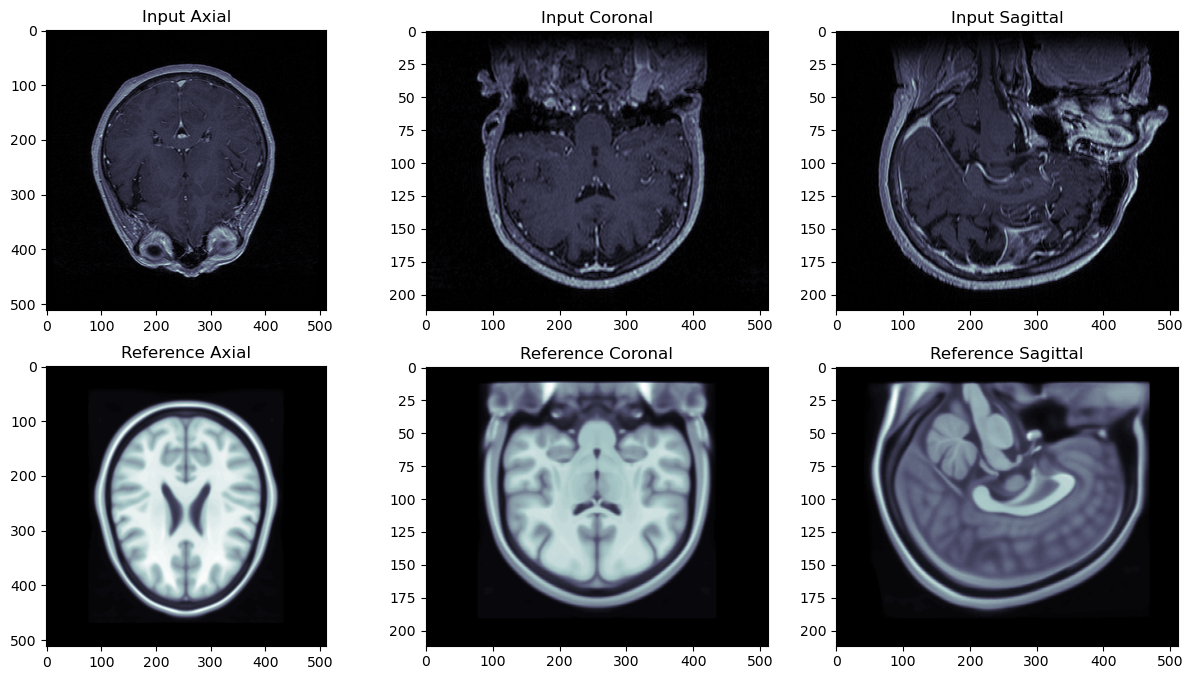

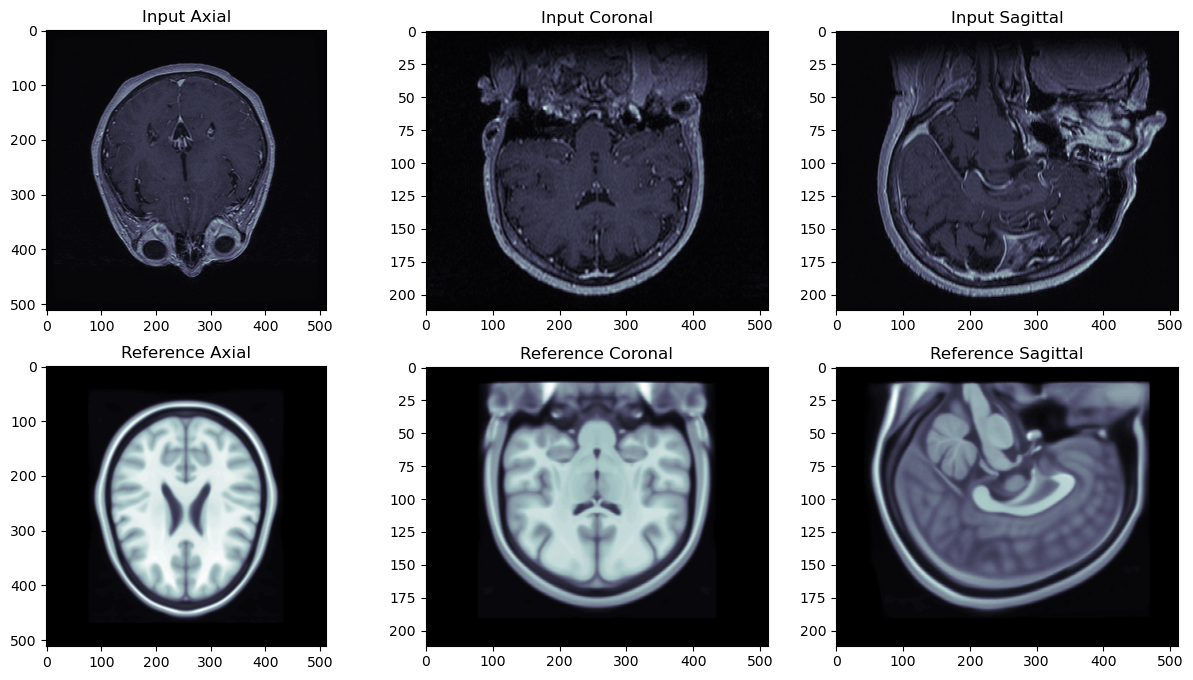

In [102]:
# we could also use scipy normalize i think 
def normalize(block):
    # need to do 3d normalization 
    min_val, max_val = np.min(block), np.max(block)
    return (block - min_val)/(max_val - min_val)
norm_input = normalize(rot_block)
norm_ref = normalize(padded_reference_block)
final_block, result, errors = coregister_image(norm_input, norm_ref, 'LE')
print("resuling errors:", errors)
print("resulting transformation parameters:", result.x)
plot_image_and_reference_comparison(rot_block, padded_reference_block,
                                    img_aspect=1.0/pixel_spacing[0],
                                    ref_aspect=1.0/pixel_spacing[0])
plot_image_and_reference_comparison(final_block, padded_reference_block,
                                    img_aspect=1.0/pixel_spacing[0],
                                    ref_aspect=1.0/pixel_spacing[0])

# Visualizing the Thalamus Region

In [103]:
atlas_path = "./p2data/AAL3_1mm.dcm"
atlas_segment = dicom.dcmread(atlas_path)
atlas_block = atlas_segment.pixel_array

In [104]:
print(atlas_block.shape)
print(np.array(ref_block.shape) - np.array(ref_block.shape))

(181, 217, 181)
[0 0 0]


In [105]:
def get_thalamus_mask(img_atlas: np.ndarray) -> np.ndarray:
    # Your code here:
    #   ...
    """
    81 Thalamus_L 
    82 Thalamus_R 
    :param img_atlas: 
    :return: 
    """
    mask = np.zeros_like(img_atlas)
    for i in range (121, 151):
        mask[img_atlas == i] = 1
    return mask


/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_54018/2067035898.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


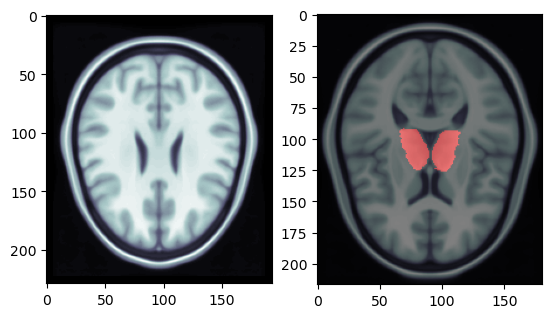

In [106]:
thalamus_mask = get_thalamus_mask(atlas_block)
img_phantom = ref_block[6:-6, 6:-6, 6:-6]     # Crop phantom to atlas size
thalamus_mask_centroid = find_centroid(thalamus_mask)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(ref_block[100, :, :], cmap='bone')
axs[1].imshow(img_phantom[100, :, :], cmap='tab20')
fig.show()

visualize_axial_slice(img_phantom, thalamus_mask, thalamus_mask_centroid)

In [107]:
print('getting volume ')

vol = find_region_volume(thalamus_mask)
surf = find_region_surface(thalamus_mask)

print('Thalamus volume:')
print(f'  >> Result: {vol} mm^3')

print('Thalamus surface:')
print(f'  >> Result: {surf} mm^2')

getting volume 
Thalamus volume:
  >> Result: 16699 mm^3
Thalamus surface:
  >> Result: 7106.0 mm^2


In [112]:
scaling_factors = (1, 1/pixel_spacing[0], 1/pixel_spacing[0])
thalamus_scaled_mask = scipy.ndimage.zoom(thalamus_mask, scaling_factors, order=1) 
thalamus_padded_scaled_mask = pad(rot_block, thalamus_scaled_mask)
thalamus_transformed_mask = transform_block(result.x, thalamus_padded_scaled_mask)

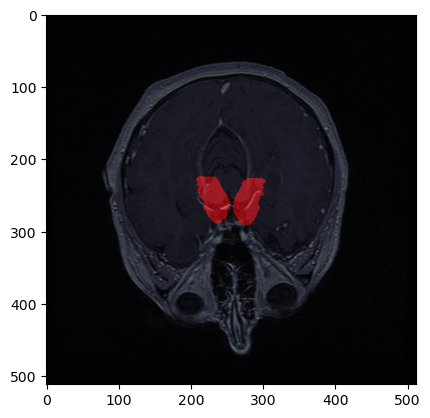

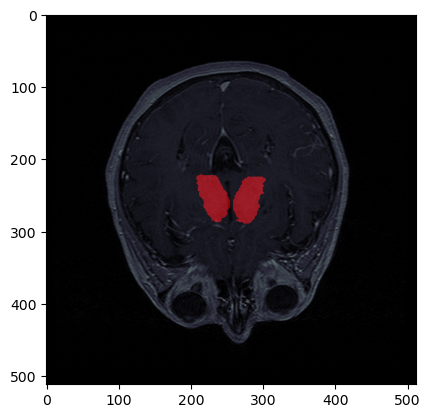

In [113]:
transformed_mask_centroid = find_centroid(thalamus_transformed_mask)
thalamust_padded_scaled_centroid = find_centroid(thalamus_padded_scaled_mask)
visualize_axial_slice(final_block, thalamus_padded_scaled_mask, thalamust_padded_scaled_centroid)
visualize_axial_slice(rot_block, thalamus_transformed_mask, transformed_mask_centroid)